In [ ]:
!pip install openpyxl
!pip install colorama

  # **1.Splitting the data into 60% training, 20% validation, and 20% testing data at random**


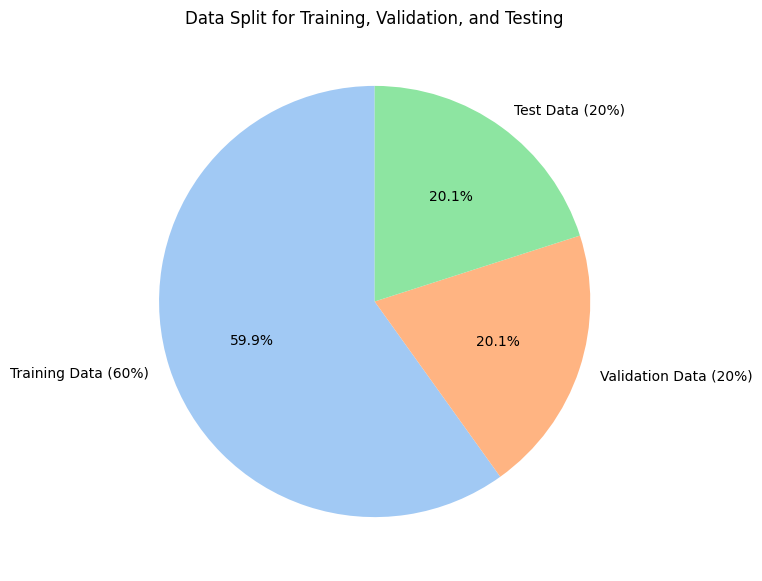

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (Energy Efficiency dataset)
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
data = pd.read_excel(url)

# Assign features (X) and target (y)
X = data.iloc[:, :-2]  # Columns X1 to X8
y = data.iloc[:, -2]   # Predicting Heating Load (Y1)

# Split the data: 60% training, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Visualization: Pie chart of data splits
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Training Data (60%)', 'Validation Data (20%)', 'Test Data (20%)']
colors = sns.color_palette('pastel')

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Data Split for Training, Validation, and Testing')
plt.show()

  # **2.Using Ridge regularization with different choices of regularization parameters**

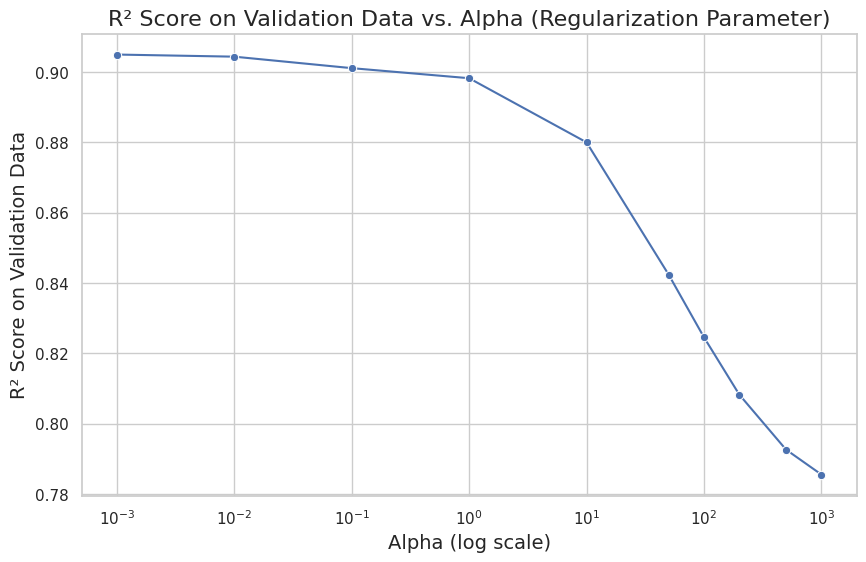

Best alpha: 0.001


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Define 10 different Ridge regularization parameters (alpha values)
alphas = [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 500, 1000]
validation_r2_scores = []

# Loop over each alpha and train the model, evaluate on validation data
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_val_pred = ridge.predict(X_val)
    r2 = r2_score(y_val, y_val_pred)
    validation_r2_scores.append(r2)

# Visualization: Plot R² scores for different regularization parameters
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.lineplot(x=alphas, y=validation_r2_scores, marker='o', color='b')
plt.xscale('log')
plt.title('R² Score on Validation Data vs. Alpha (Regularization Parameter)', fontsize=16)
plt.xlabel('Alpha (log scale)', fontsize=14)
plt.ylabel('R² Score on Validation Data', fontsize=14)
plt.show()

# Best alpha
best_alpha = alphas[validation_r2_scores.index(max(validation_r2_scores))]
print(f'Best alpha: {best_alpha}')

  # 3. Final evaluation on the test data

R² on test set: 0.9190947644935202


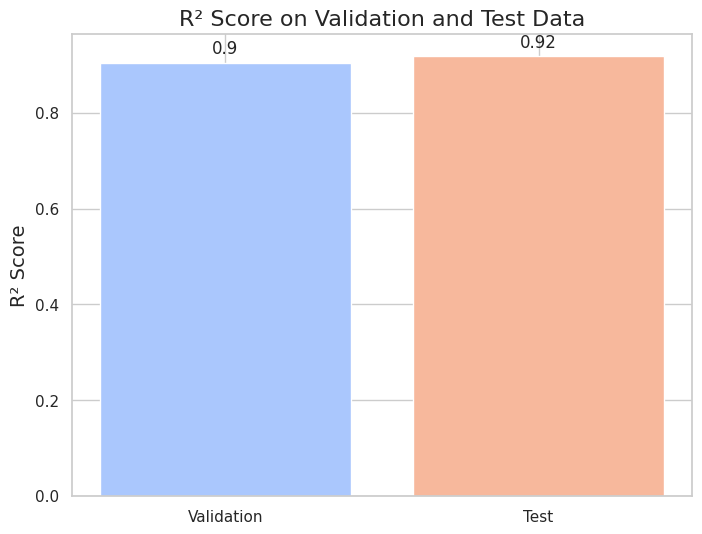

In [ ]:
# Train the Ridge model using the best alpha on the combined training and validation sets
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Predict on test set and evaluate
y_test_pred = best_ridge.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

print(f'R² on test set: {test_r2}')

# Visualization: Bar chart showing R² score for validation and test sets
plt.figure(figsize=(8, 6))
bars = plt.bar(['Validation', 'Test'],
               [max(validation_r2_scores), test_r2],
               color=sns.color_palette("coolwarm", 2))
plt.title('R² Score on Validation and Test Data', fontsize=16)
plt.ylabel('R² Score', fontsize=14)

# Annotating the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()

##   **4. Best model’s coefficients, intercept, and accuracies (R² scores) for training, validation, and test sets**

Coefficients: [-6.55366574e+01 -6.12664973e-02  3.35417227e-02 -4.74043397e-02
  4.35503210e+00 -6.45989773e-03  2.00422014e+01  2.21752813e-01]
Intercept: 83.03387123696402
R² on training set: 0.9177795572678031
R² on validation set: 0.9077992149002307
R² on test set: 0.9190947644935202


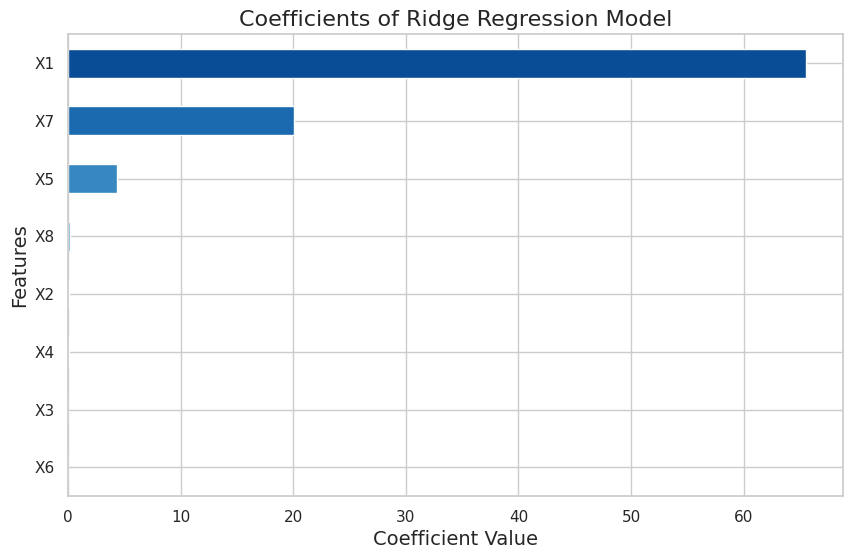

In [ ]:
# Coefficients and intercept of the best model
print('Coefficients:', best_ridge.coef_)
print('Intercept:', best_ridge.intercept_)

# R² score for training and validation sets
train_r2 = best_ridge.score(X_train, y_train)
val_r2 = best_ridge.score(X_val, y_val)

print(f'R² on training set: {train_r2}')
print(f'R² on validation set: {val_r2}')
print(f'R² on test set: {test_r2}')

# Visualization: Coefficients of the model
coefficients = pd.Series(best_ridge.coef_, index=X.columns)
plt.figure(figsize=(10, 6))
coefficients.abs().sort_values().plot(kind='barh', color=sns.color_palette("Blues", len(coefficients)))
plt.title('Coefficients of Ridge Regression Model', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

### **5. Top 5 features based on their coefficients**

Top 5 features: ['X1', 'X7', 'X5', 'X8', 'X2']


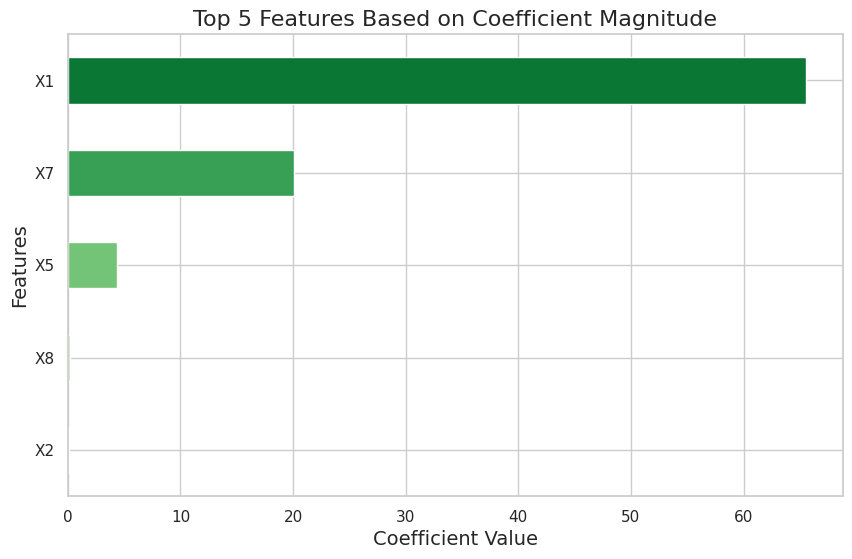

In [ ]:
# Get the top 5 features based on the absolute values of the coefficients
top_5_features = coefficients.abs().nlargest(5)
print('Top 5 features:', top_5_features.index.tolist())

# Visualization: Top 5 features with their coefficient values
plt.figure(figsize=(10, 6))
top_5_features.sort_values().plot(kind='barh', color=sns.color_palette("Greens", len(top_5_features)))
plt.title('Top 5 Features Based on Coefficient Magnitude', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

# **6. Repeating the procedure using only the top 5**

R² on validation set with top 5 features: 0.8988167172363036
R² on test set with top 5 features: 0.9071326495333917


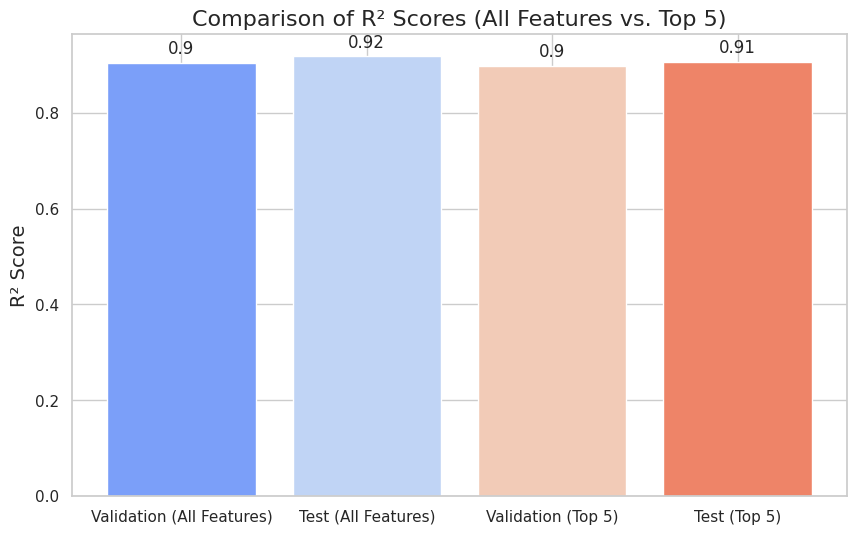

In [ ]:
# Select the top 5 features for retraining
X_top_5_train = X_train[top_5_features.index]
X_top_5_val = X_val[top_5_features.index]
X_top_5_test = X_test[top_5_features.index]

# Retrain the model using the top 5 features
ridge_top_5 = Ridge(alpha=best_alpha)
ridge_top_5.fit(X_top_5_train, y_train)

# Evaluate on validation and test sets
y_top_5_val_pred = ridge_top_5.predict(X_top_5_val)
y_top_5_test_pred = ridge_top_5.predict(X_top_5_test)

val_r2_top_5 = r2_score(y_val, y_top_5_val_pred)
test_r2_top_5 = r2_score(y_test, y_top_5_test_pred)

print(f'R² on validation set with top 5 features: {val_r2_top_5}')
print(f'R² on test set with top 5 features: {test_r2_top_5}')

# Visualization: Comparison of R² scores using all features and top 5 features
plt.figure(figsize=(10, 6))
bars = plt.bar(['Validation (All Features)', 'Test (All Features)', 'Validation (Top 5)', 'Test (Top 5)'],
               [max(validation_r2_scores), test_r2, val_r2_top_5, test_r2_top_5],
               color=sns.color_palette("coolwarm", 4))
plt.title('Comparison of R² Scores (All Features vs. Top 5)', fontsize=16)
plt.ylabel('R² Score', fontsize=14)

# Annotating the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()

## **GUIDED QUESTION**

# **1. What is the impact of removing certain features on the model’s performance?**

Removing features can affect the model's performance. If you remove important features, the model's accuracy will drop. But if you remove unnecessary or redundant features, the model can actually improve by becoming simpler and better at handling new data. We can compare the model's performance with all features and with only the top 5 important features by looking at their coefficients.

R² score on test data using all features: 0.9190947644935202
R² score on test data using top 5 features: 0.9071326495333917


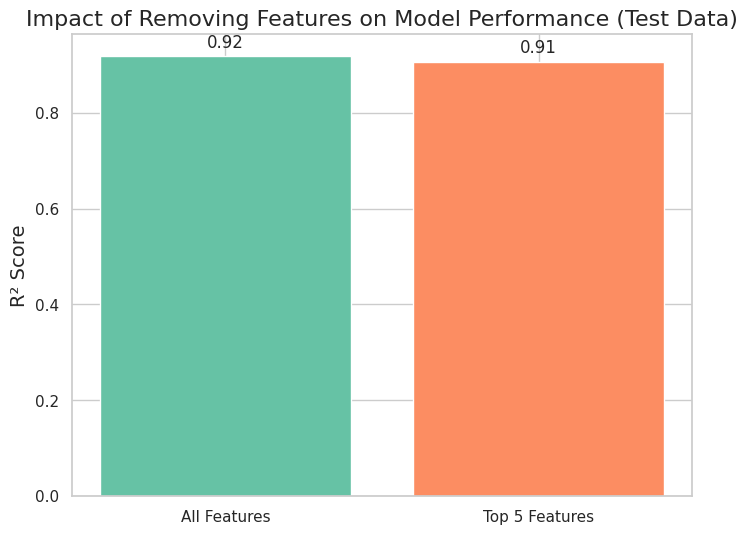

In [ ]:
from sklearn.metrics import r2_score

# Model trained with all features (already trained)
test_r2_all = r2_score(y_test, y_test_pred)

# Model trained with top 5 features
ridge_top_5 = Ridge(alpha=best_alpha)
ridge_top_5.fit(X_top_5_train, y_train)
y_top_5_test_pred = ridge_top_5.predict(X_top_5_test)
test_r2_top_5 = r2_score(y_test, y_top_5_test_pred)

print(f'R² score on test data using all features: {test_r2_all}')
print(f'R² score on test data using top 5 features: {test_r2_top_5}')

# Visualization: Comparison
plt.figure(figsize=(8, 6))
bars = plt.bar(['All Features', 'Top 5 Features'], [test_r2_all, test_r2_top_5], color=sns.color_palette("Set2", 2))
plt.title('Impact of Removing Features on Model Performance (Test Data)', fontsize=16)
plt.ylabel('R² Score', fontsize=14)

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()

 **2. Why is it necessary to split the data into training, validation, and testing sets? What could happen if this step is skipped?**

In machine learning, we split data into a training set, validation set, and test set. The training set helps the model learn, the validation set fine-tunes it, and the test set checks how well it works on new data. Skipping this step can cause overfitting, where the model does well on training data but fails on new data. It can also lead to biased performance results, making the model seem better than it really is.


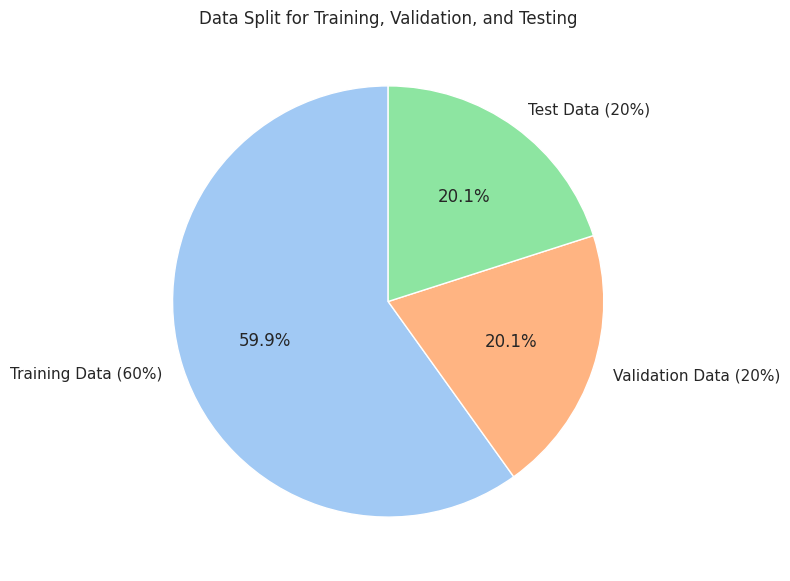

In [ ]:
# Assign features (X) and target (y)
X = data.iloc[:, :-2]  # Columns X1 to X8
y = data.iloc[:, -2]   # Predicting Heating Load (Y1)

# Split the data: 60% training, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Visualization: Pie chart of data splits
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Training Data (60%)', 'Validation Data (20%)', 'Test Data (20%)']
colors = sns.color_palette('pastel')

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Data Split for Training, Validation, and Testing')
plt.show()

**3. How can the generalization ability of the model be assessed using the test data? What steps would you take to ensure the model generalizes well to unseen data?**


Generalization refers to how well a model performs on unseen data. To ensure good generalization, we:

Split data into training, validation, and test sets properly.

Use regularization (e.g., Ridge regression) to prevent overfitting.

Apply cross-validation to check consistency across different data subsets.
Select important features to reduce noise and improve performance.


R² on test set: 0.9190947644935202


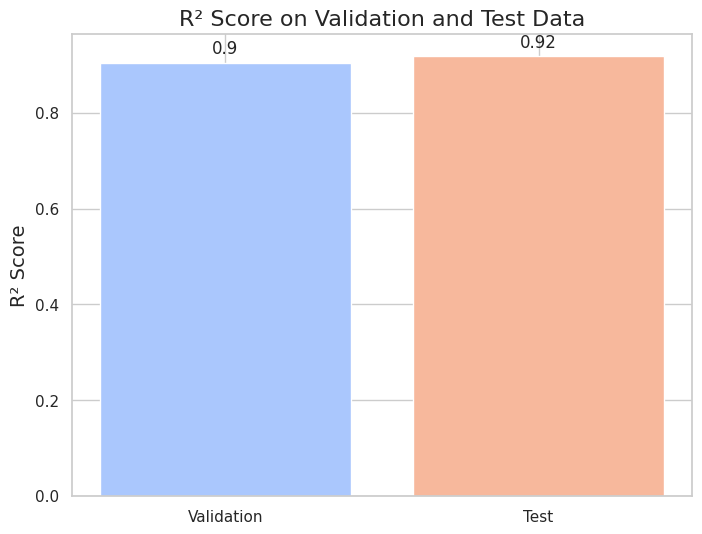

In [ ]:
# Train the Ridge model using the best alpha on the combined training and validation sets
best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Predict on test set and evaluate
y_test_pred = best_ridge.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)

print(f'R² on test set: {test_r2}')

# Visualization: Bar chart showing R² score for validation and test sets
plt.figure(figsize=(8, 6))
bars = plt.bar(['Validation', 'Test'],
               [max(validation_r2_scores), test_r2],
               color=sns.color_palette("coolwarm", 2))
plt.title('R² Score on Validation and Test Data', fontsize=16)
plt.ylabel('R² Score', fontsize=14)

# Annotating the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.show()